In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from pandas import DataFrame
import warnings
warnings.filterwarnings("ignore")

In [2]:
EPL = pd.read_csv('ranking.csv')

In [3]:
EPL
#YEAR: 리그 년도
#RANK: 리그 순위
#GF: 전체 득점 (GOALS FOR)
#GA: 전체 실점 (GOALS AGAINST)
#GD: 전체 득점-실점 (GOALS DIFFERENCE)
#WIN: 전체 승리
#DRAW: 전체 무승부
#LOSE: 전체 패배
#POINT: 승점
#EPL: EPL 우승 여부(yes: 우승, no: 우승 실패)
#UCL: 챔피언스리그 진출 여부(yes:진출 성공, no: 진출 실패)
#RELEGATION: 강등 여부 (yes: 강등, no: 잔류)

,YEAR,RANK,GF,GA,GD,WIN,DRAW,LOSE,POINT,EPL,UCL,RELEGATION
0,1995년,1,73,35,38,25,7,6,82,yes,yes,no
1,1995년,2,66,37,29,24,6,8,78,no,yes,no
2,1995년,3,70,34,36,20,11,7,71,no,yes,no
3,1995년,4,52,35,17,18,9,11,63,no,yes,no
4,1995년,5,49,32,17,17,12,9,63,no,no,no
...,...,...,...,...,...,...,...,...,...,...,...,...
315,2010년,16,40,61,-21,9,15,14,42,no,no,no
316,2010년,17,46,66,-20,11,7,20,40,no,no,no
317,2010년,18,37,58,-21,8,15,15,39,no,no,yes
318,2010년,19,55,78,-23,10,9,19,39,no,no,yes


In [4]:
# 2번째로 EPL 우승을 하기 위한 조건을 알아내기 위해 classification을 통해 decision tree를 알아낼 것이다.

In [5]:
#전처리 과정
# classifying attribute로 득점, 실점, 승, 무, 패를 다루고 target attribute를 챔피언스리그 진출 여부로 정했기에 
# classification과 관련없는 attribute인 'YEAR','RANK','GD','POINT','EPL', 'RELEGATION'는 제외할 것이다. 
EPL1=EPL.drop(['YEAR','RANK','GD','POINT','EPL', 'RELEGATION'],axis=1,inplace=True)

In [6]:
EPL

,GF,GA,WIN,DRAW,LOSE,UCL
0,73,35,25,7,6,yes
1,66,37,24,6,8,yes
2,70,34,20,11,7,yes
3,52,35,18,9,11,yes
4,49,32,17,12,9,no
...,...,...,...,...,...,...
315,40,61,9,15,14,no
316,46,66,11,7,20,no
317,37,58,8,15,15,no
318,55,78,10,9,19,no


In [7]:
#classification을 위해 training data와 test data를 7:3의 비율로 나누었다.
feature_cols = ['GF', 'GA', 'WIN', 'DRAW', 'LOSE']

X = EPL[feature_cols]
y = EPL.UCL

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=100)

In [8]:
#decision tree 기법을 사용하기 위해서는 어떤 attribute를 기준으로 몇번 분화를 하는지를 결정해야 한다.
#어떤 attribute를 기준으로 몇번 분화를 하는지를 결정하기 위해서는 information gain, gini index등의 classifier값을 구해서 그 classifier값이 큰 것 순으로 분화를 한다.
# 어떤 classifier값을 사용할지를 지금 구할 것이다.

In [9]:
param_grid = {
    'criterion':['gini', 'entropy'],
    'max_depth': list(range(2, 16)),
    'min_samples_leaf': list(range(1, 6)),
    'min_samples_split': list(range(2, 6)),
    'random_state':[10]
}

clf = GridSearchCV(DecisionTreeClassifier(), param_grid, n_jobs=-1, cv=5)

In [10]:
%time clf.fit(X_train, y_train)

Wall time: 12.4 s


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,
                                       14, 15],
                         'min_samples_leaf': [1, 2, 3, 4, 5],
                         'min_samples_split': [2, 3, 4, 5],
                         'random_state': [10]})

In [11]:
clf.best_params_

{'criterion': 'gini',
 'max_depth': 3,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'random_state': 10}

In [12]:
#clf.best_params_를 통해서
#gini를 기준으로 3번 분화하는 게 가장 적절하다는 결과값이 나온다.

In [13]:
my_model = clf.best_estimator_
my_model.fit(X_train, y_train)
my_model_score_train = my_model.score(X_train, y_train)
my_model_score_test = my_model.score(X_test, y_test)

print(clf.best_estimator_)
print('Training data의 accuracy = ',my_model_score_train)
print('Testing data의 accuracy = ',my_model_score_test)

DecisionTreeClassifier(max_depth=3, random_state=10)
Training data의 accuracy =  0.9910714285714286
Testing data의 accuracy =  0.96875


In [14]:
#그러면 gini index를 기준으로 attribute의 중요도를 구할 것이다.

features = pd.DataFrame(X.columns.tolist())
features.columns = ['Features']
fi = pd.DataFrame(my_model.feature_importances_)
fi.columns = ['Value']
fea_imp = pd.concat([features, fi], axis=1)
fea_imp.sort_values(by='Value', ascending = False)

,Features,Value
2,WIN,0.909957
0,GF,0.086043
1,GA,0.004000
3,DRAW,0.000000
4,LOSE,0.000000


In [15]:
from sklearn.tree import DecisionTreeClassifier
treeclf = DecisionTreeClassifier(max_depth=3, random_state=1)
treeclf.fit(X, y)

DecisionTreeClassifier(max_depth=3, random_state=1)

In [16]:
#decision tree의 대략적인 모양을 만들었다.

from sklearn import tree
text_representation = tree.export_text(treeclf)
print(text_representation)

#feature_0: 득점(GF)
#feature_1: 실점(GA)
#feature_2: 승(WIN)
#feature_3: 무(DRAW)
#feature_4: 패(LOSE)

|--- feature_2 <= 18.50
|   |--- feature_2 <= 17.50
|   |   |--- feature_1 <= 37.50
|   |   |   |--- class: no
|   |   |--- feature_1 >  37.50
|   |   |   |--- class: no
|   |--- feature_2 >  17.50
|   |   |--- feature_0 <= 52.50
|   |   |   |--- class: yes
|   |   |--- feature_0 >  52.50
|   |   |   |--- class: no
|--- feature_2 >  18.50
|   |--- feature_4 <= 11.50
|   |   |--- feature_0 <= 56.00
|   |   |   |--- class: no
|   |   |--- feature_0 >  56.00
|   |   |   |--- class: yes
|   |--- feature_4 >  11.50
|   |   |--- feature_4 <= 14.00
|   |   |   |--- class: no
|   |   |--- feature_4 >  14.00
|   |   |   |--- class: yes



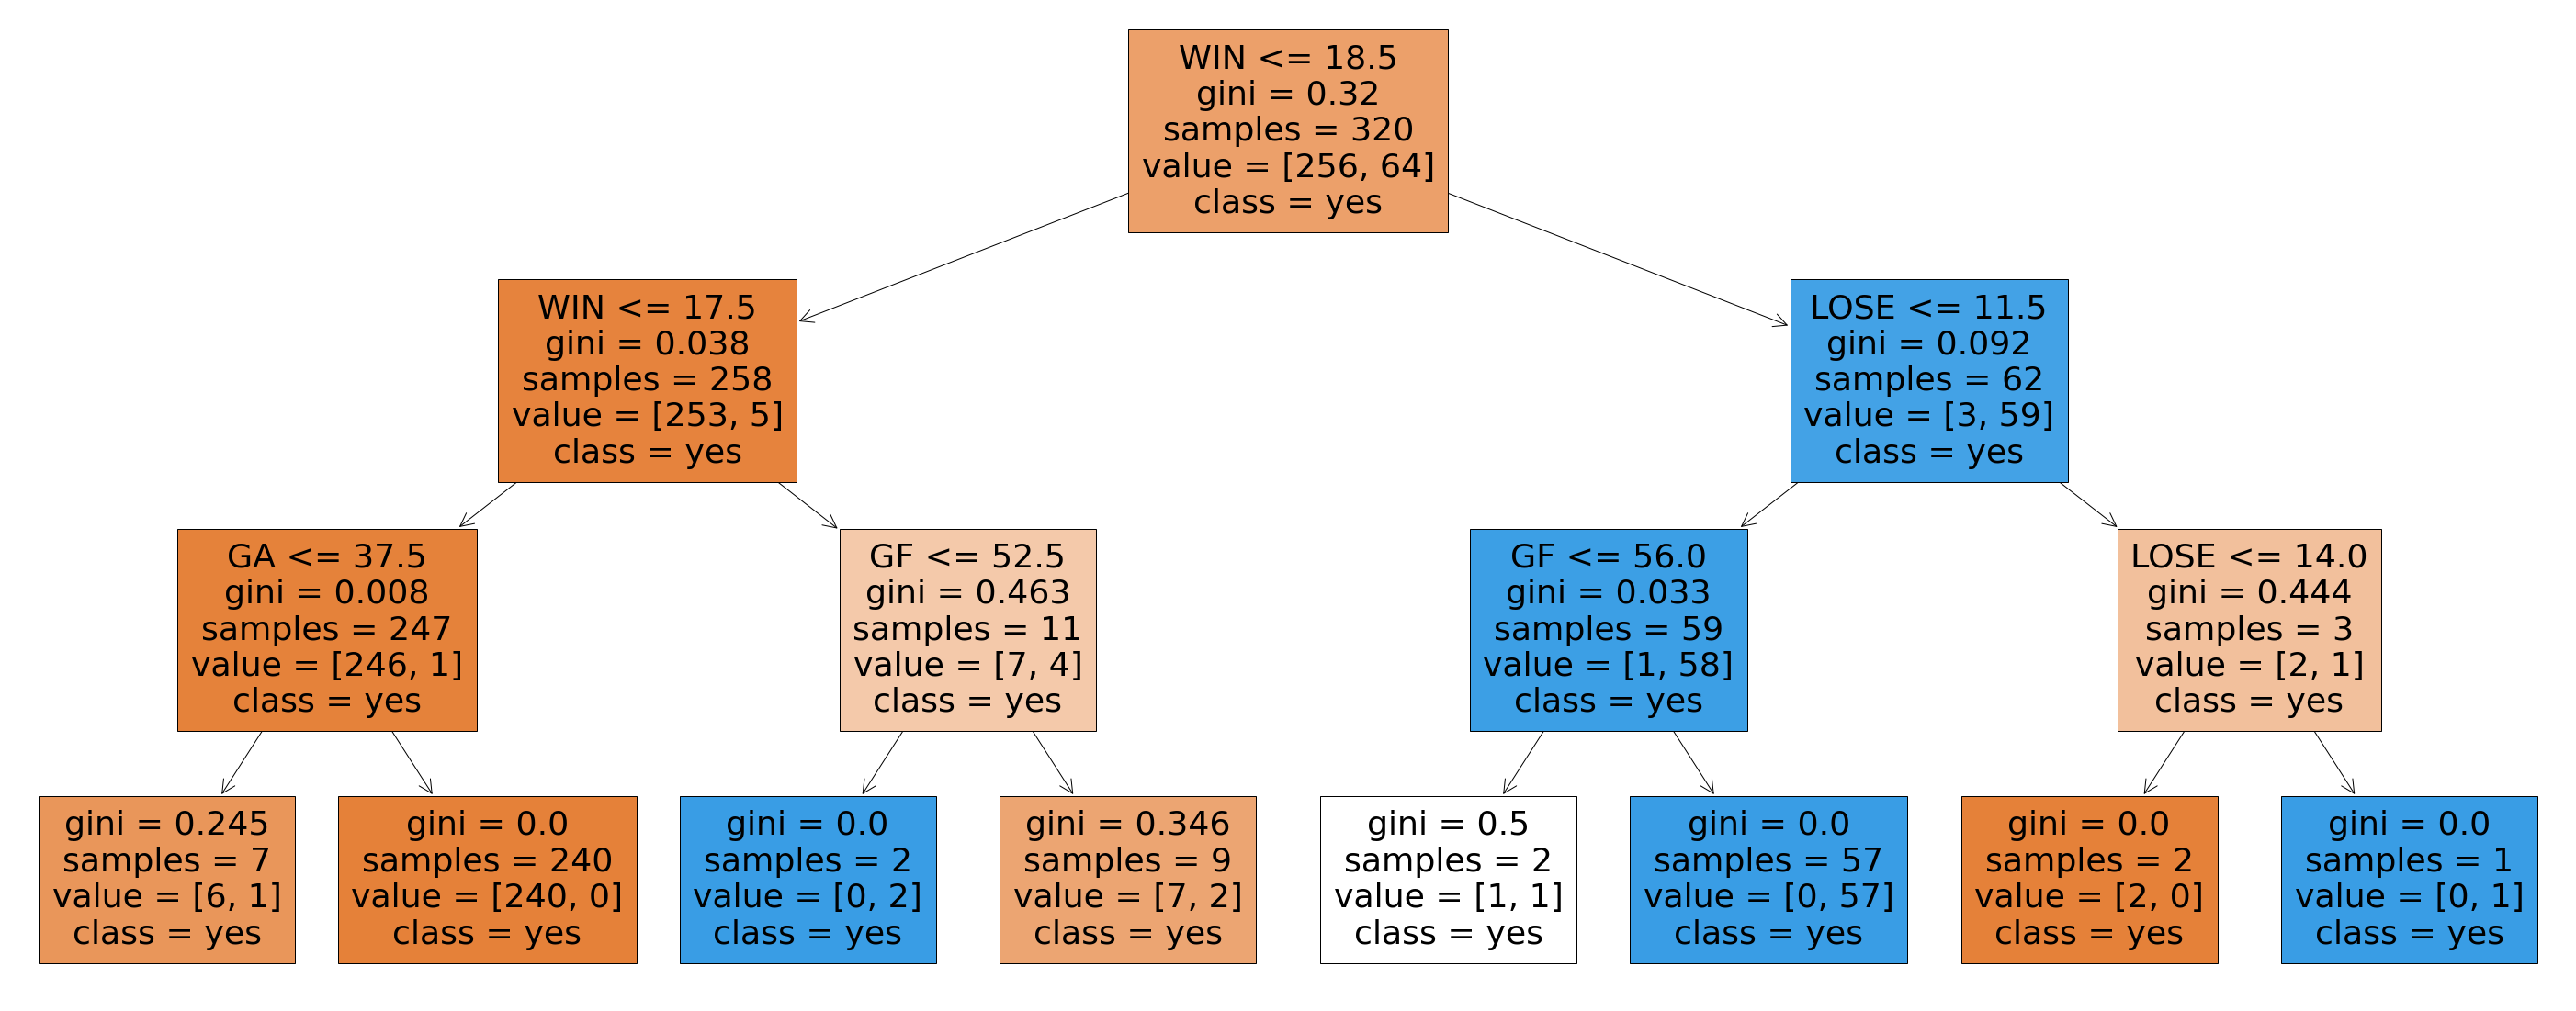

In [17]:
#이제 제대로 된 decision tree를 만들 것이다.
with open("decision_tree.log", "w") as fout:
    fout.write(text_representation)
fig = plt.figure(figsize=(50,20))
_ = tree.plot_tree(treeclf, 
                   feature_names=feature_cols,  
                   class_names=EPL.UCL.astype(str),
                   filled=True)

In [18]:
#1.승리 17.5번 이하- UCL 진출 실패  
#2.승리 17.5번 초과 18.5번 이하, 득점 52.5개 이하-UCL 진출 성공 
#3.승리 17.5번 초과 18.5번 이하, 득점 52.5개 이상-UCL 진출 실패
#(원래 2번과 3번을 비교했을 때 득점이 많은 수록 UCL 진출 확률이 높아지는데 2번과 3번은 거꾸로다. 서로 다른 시즌의 결과들을 비교하느라 어쩔 수 없는 결과이다.)
#4.승리 18.5번 초과, 패배 11.5번 이하, 득점 56개 이하-UCL 진출 실패
#5.승리 18.5번 초과, 패배 11.5번 이하, 득점 56개 초과-UCL 진출 성공
#6.승리 18.5번 초과, 패배 11.5번 초과, 14번 이하- UCL 진출 실패
#7.승리 18.5번 초과, 패배 14번 초과- UCL 진출 성공
#(원래 6번과 7번을 비교했을 때 패배가 적을 수록 UCL 진출 확률이 높아지는데 6번과 7번은 거꾸로다. 서로 다른 시즌의 결과들을 비교하느라 어쩔 수 없는 결과이다.)